### Stationarity check

Depending on whether the mean, variance and autocorrelation stay constant over time we can work out which machine learning method can work best with the data given its inherent assumptions

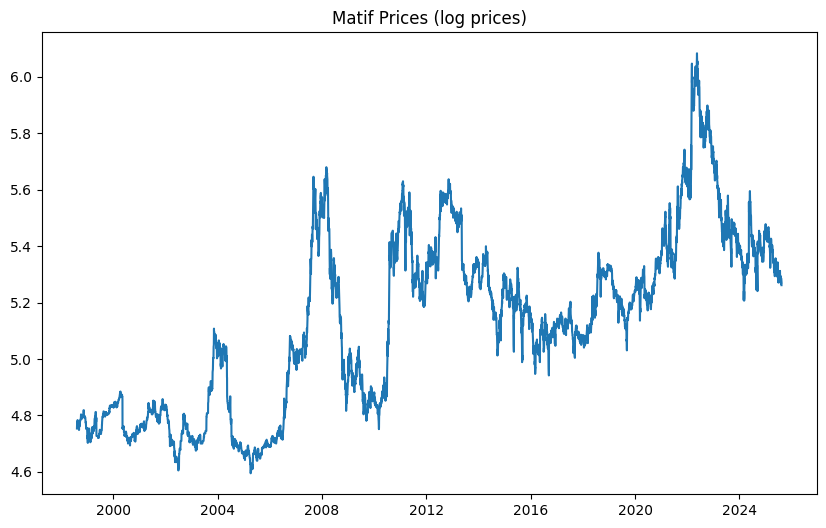

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("data/xlsx_data/DatasetTrainingMatif20250812.xlsx", parse_dates=["Period"]).rename(columns={"Period": "Date"}).set_index("Date").sort_index()
y = np.log(df["Matif_Prices"]) # More stable for modeling
# y = df["Matif_Prices"]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y)
plt.title("Matif Prices (log prices)")
plt.show()

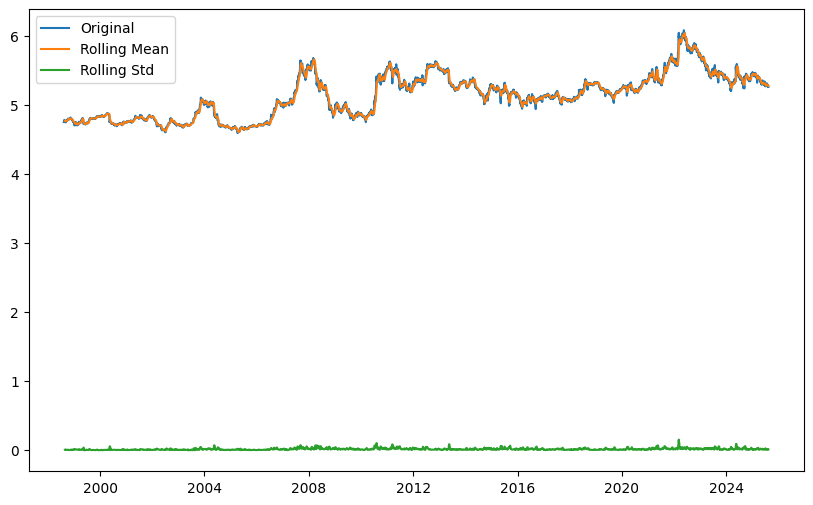

In [36]:
import pandas as pd

rolling_mean = y.rolling(window=12).mean()
rolling_std = y.rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(y, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.show()


In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import warnings

warnings.filterwarnings("ignore")

result = adfuller(y)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print()

result = kpss(y, regression='c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

warnings.filterwarnings("default")

ADF Statistic: -2.1959396810342398
p-value: 0.20772241762863242

KPSS Statistic: 7.741618408520016
p-value: 0.01


The Matif Price fails the stationarity check. We transofr the data to make it stationary by taking the first difference of the log matif prices.

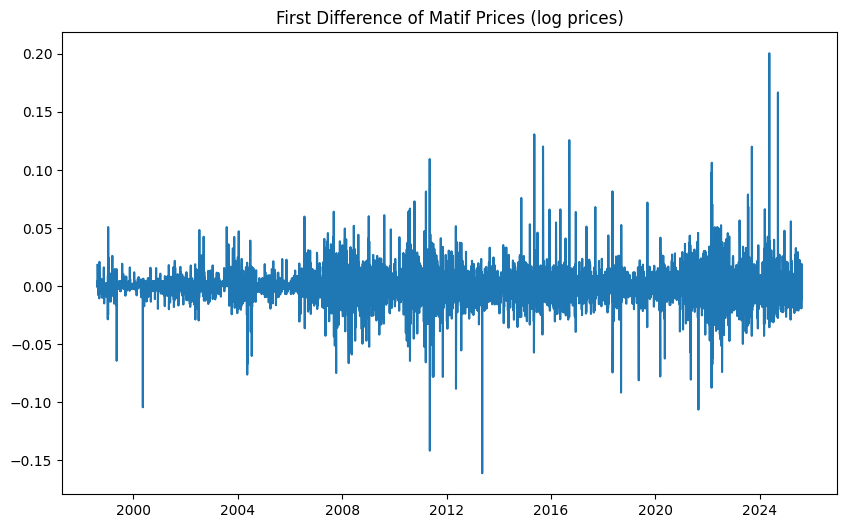

In [42]:
diff_y = y.diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(diff_y)
plt.title("First Difference of Matif Prices (log prices)")
plt.show()


In [43]:
warnings.filterwarnings("ignore")

result = adfuller(diff_y)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print()

result = kpss(diff_y, regression='c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

warnings.filterwarnings("default")

ADF Statistic: -32.64049295828763
p-value: 0.0

KPSS Statistic: 0.04145452897684873
p-value: 0.1


Since the data is now converted and stationary we test for autocorrelation, usually commodities tend to have high autocorrelation.

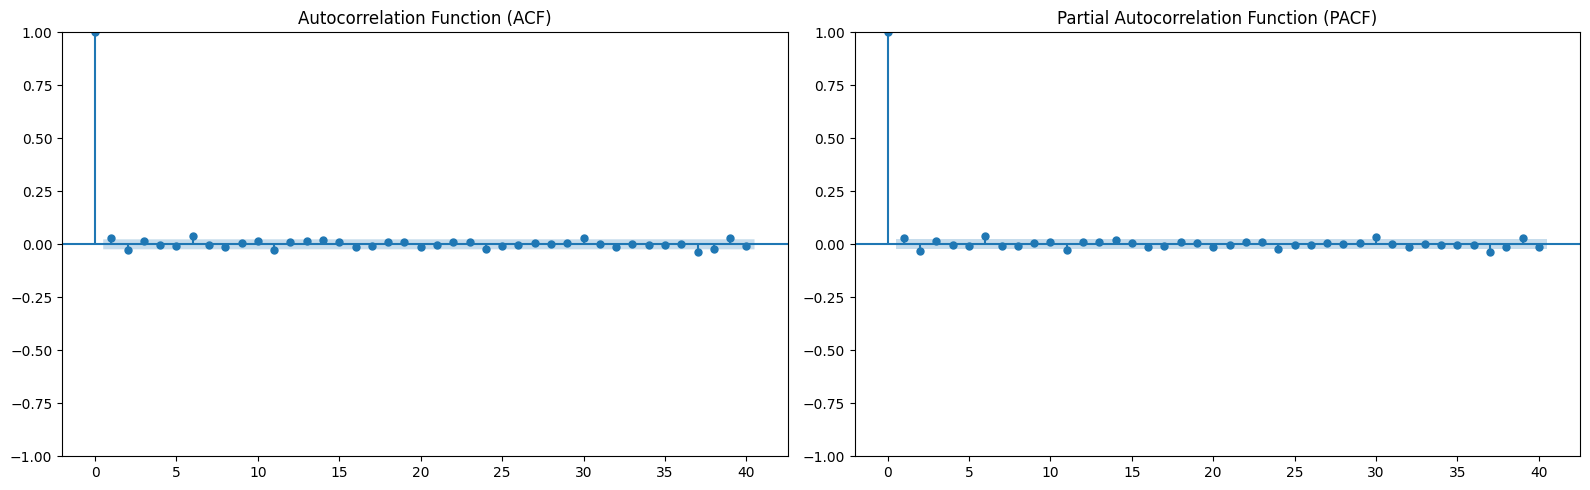

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_y, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(diff_y, lags=40, method='ywm', ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [58]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
model = ARIMA(y, order=(0, 1, 0)) # 1st difference
result = model.fit()
print(result.summary())
warnings.filterwarnings("default")

                               SARIMAX Results                                
Dep. Variable:           Matif_Prices   No. Observations:                 6914
Model:                 ARIMA(0, 1, 0)   Log Likelihood               19351.613
Date:                Sun, 05 Oct 2025   AIC                         -38701.227
Time:                        15:47:37   BIC                         -38694.385
Sample:                             0   HQIC                        -38698.868
                               - 6914                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.14e-06    190.620      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   5.48   Jarque-Bera (JB):            104491.04
Prob(Q):                              0.02   Pr

In [57]:
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")
for order in [(1,1,0), (0,1,1), (1,1,1)]:
    result = ARIMA(df['Matif_Prices'], order=order).fit()
    print(order, result.aic)
warnings.filterwarnings("default")

(1, 1, 0) 35868.50179670721
(0, 1, 1) 35868.3340948214
(1, 1, 1) 35865.5195298297


/Users/svetozarmiloshevski/Svetozar Personal/PERSONAL PROJECTS/MY REPO/personal-projects/trading/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


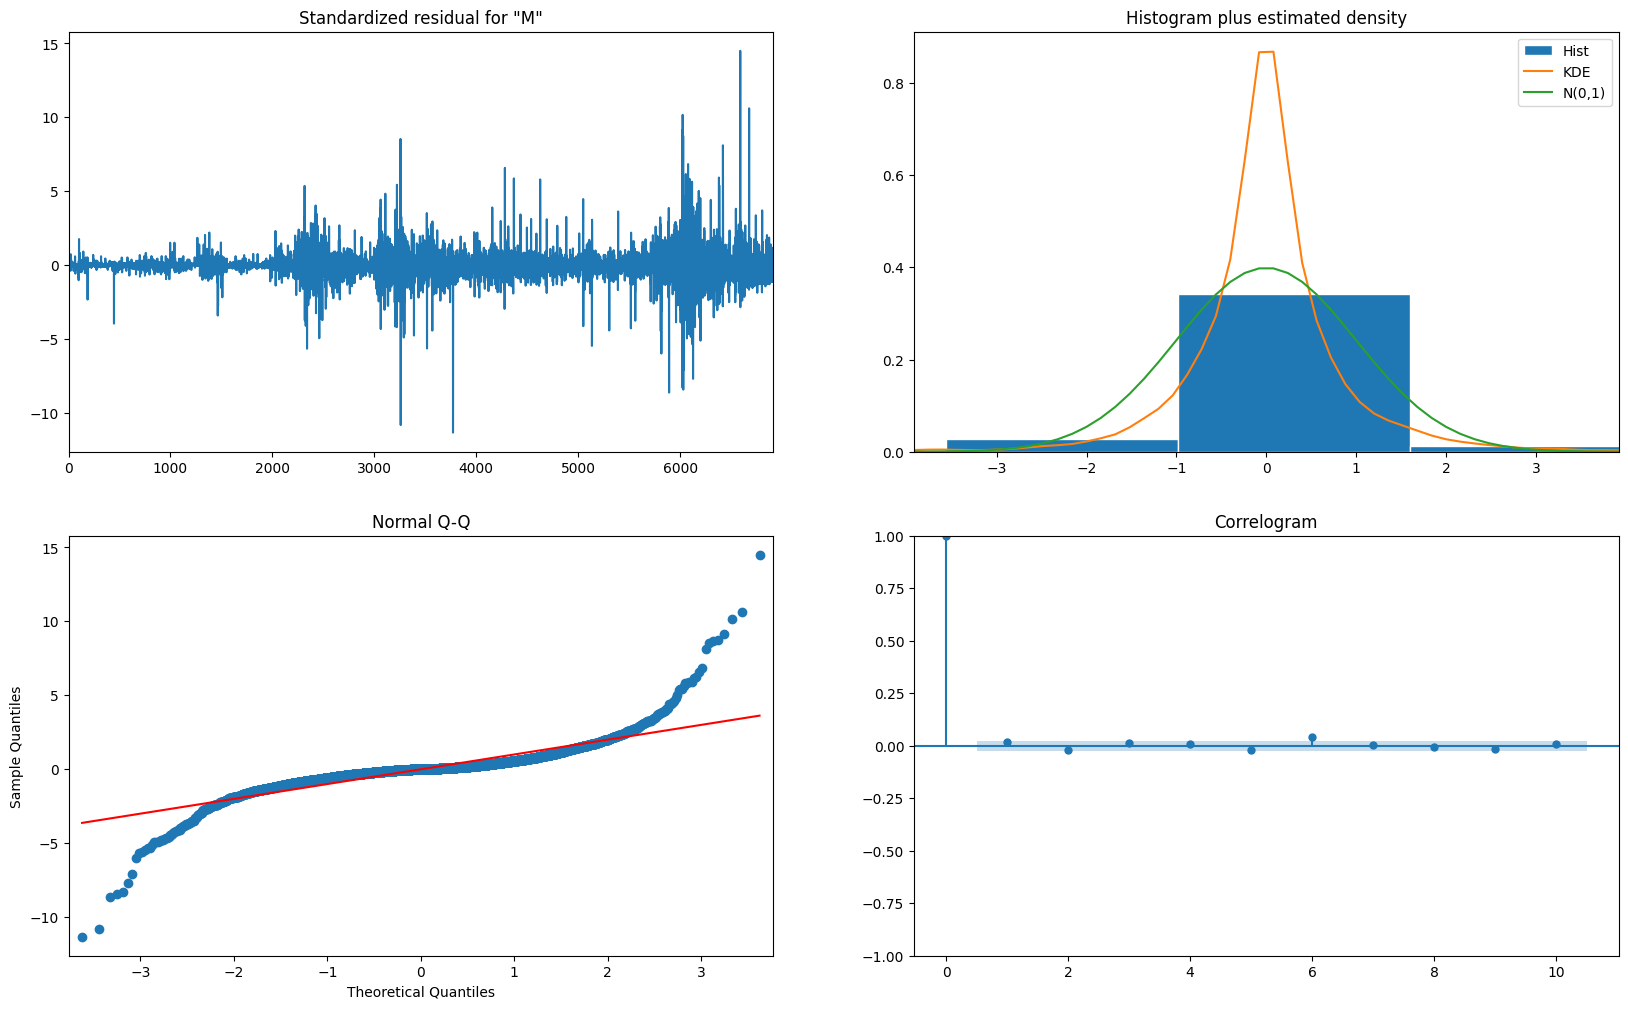

In [61]:
result = ARIMA(df['Matif_Prices'], order=(1,1,1)).fit()
result.plot_diagnostics(figsize=(20,12))
plt.show()


Data exhibits heteroskedasticity and heavy skewed tails, which means that it will be difficult to model log prices. Another possible option is modelling log returns

### Log Returns Exploration

<Axes: title={'center': 'Log Returns of Matif Prices'}, xlabel='Date'>

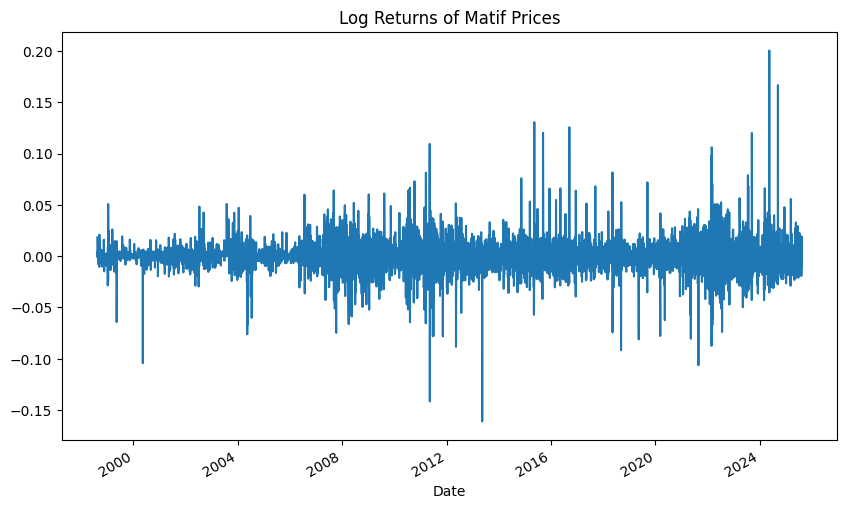

In [62]:
import numpy as np
log_returns = np.log(df['Matif_Prices'] / df['Matif_Prices'].shift(1)).dropna()
log_returns.plot(figsize=(10,6), title='Log Returns of Matif Prices')

0.0
0.1


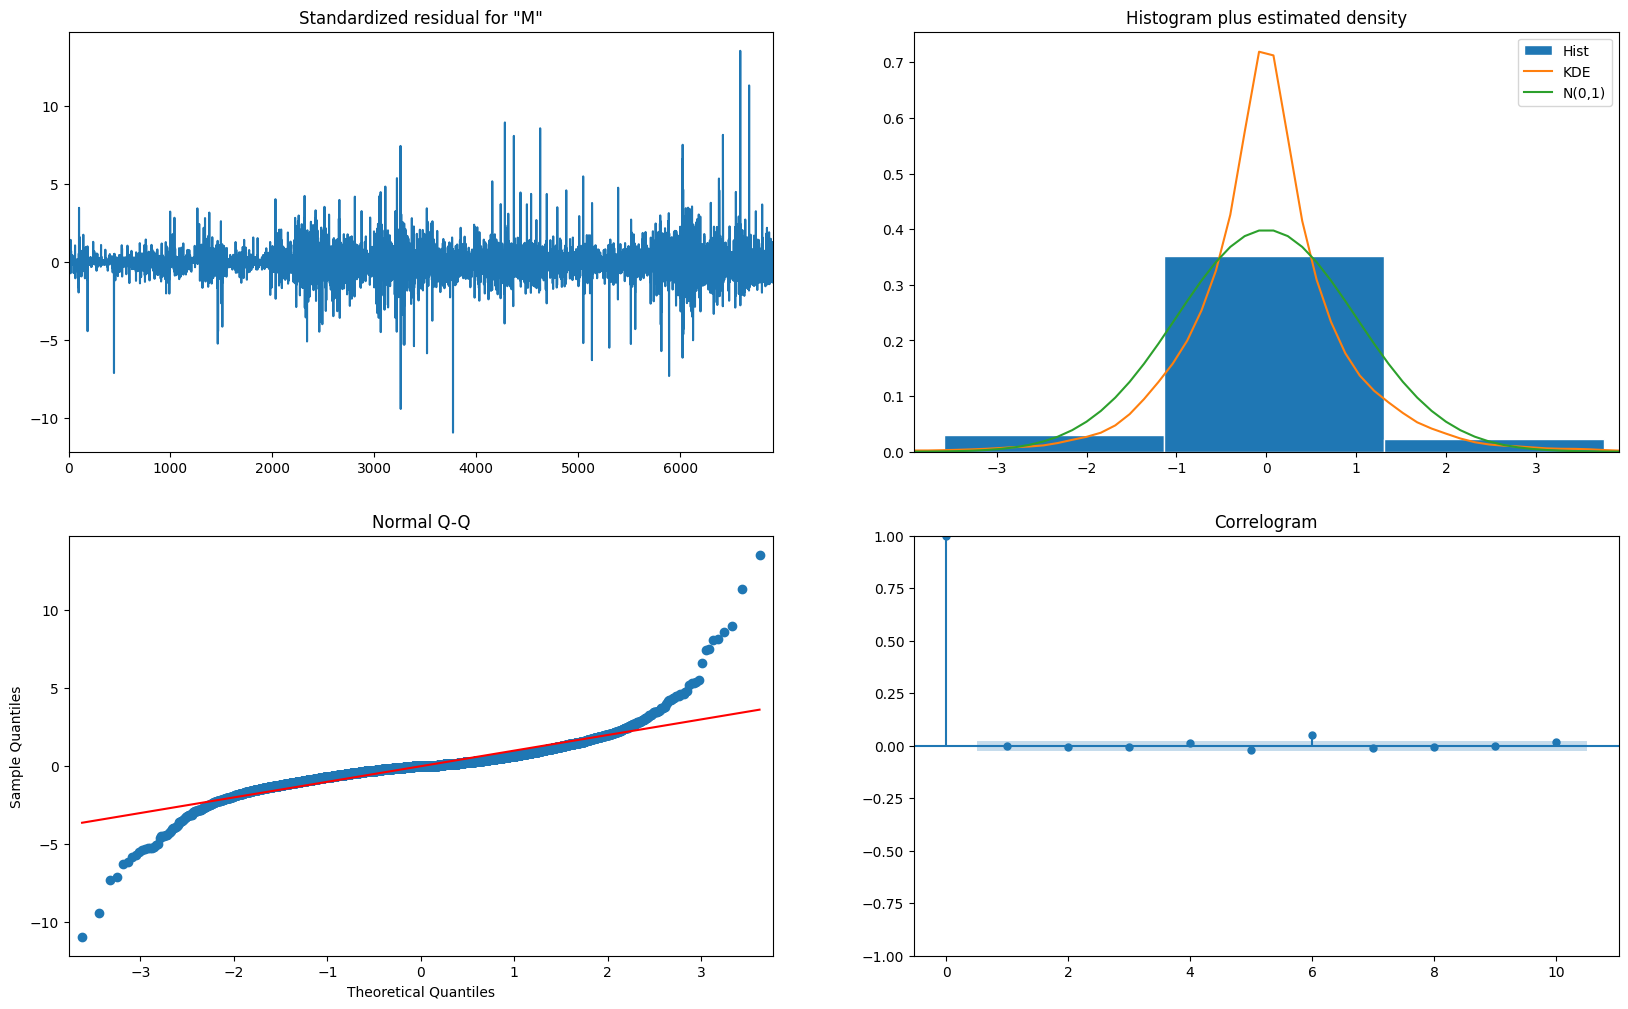

In [ ]:
warnings.filterwarnings("ignore")
print(adfuller(log_returns)[1])
print(kpss(log_returns, regression='c')[1])
result = ARIMA(log_returns, order=(1,0,1)).fit() # Already diifferenced by pct log returns
result.plot_diagnostics(figsize=(20,12))
plt.show()
warnings.filterwarnings("default")